## 读取BTCUSDT:binance频率为1H的数据

In [1]:
import warnings
warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180101000000}
Time_dict = ds.bar_reader(path,props)

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()
dv.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


### 因子一：Alpha191之alpha003

从公式上看，alpha003计算的是多空力量强度，大于零表示在6日内多方力量强于空方，小于零表示多方力量弱于空方；绝对值越大某一方力量越强。
公式分解来看，就是
if close==Delay(close,1):
    alpha3=0
elif close>Delay(close,1): 
    alpha3=max(close-low,close-Delay(close,1))
else:          
    alpha3=min(close-high,close-Delay(close,1))
最后计算累计6日的和

**alpha3的统计特征**

In [2]:
dv.add_formula('alpha3',"Ts_Sum(If((close==Delay(close,%s)),0,close-(If((close>Delay(close,%s)),Min(low,Delay(close,%s)),Max(high,Delay(close,%s))))),%s)"%(1,1,1,1,6),add_data=True)
alpha3=dv.get_ts('alpha3',date_type='datetime')
alpha3.describe()

symbol,BTCUSDT:binance
count,6279.000000
mean,1.685426
std,299.002739
min,-2205.610000
25%,-92.225000
50%,11.830000
75%,109.085000
max,2709.860000


**alpha3的频数分布直方图**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000DADD48A0B8>]],
      dtype=object)

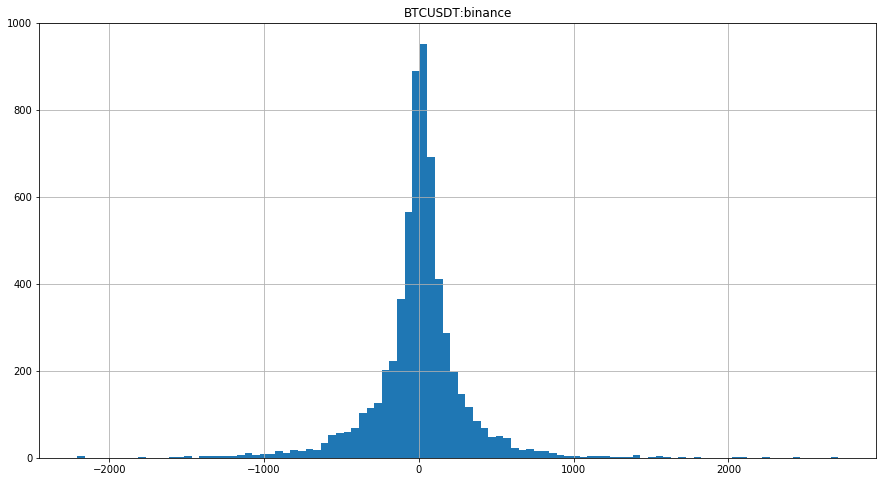

In [3]:
alpha3.hist(bins=100,figsize=(15,8))

**alpha3与收盘价的时序图**

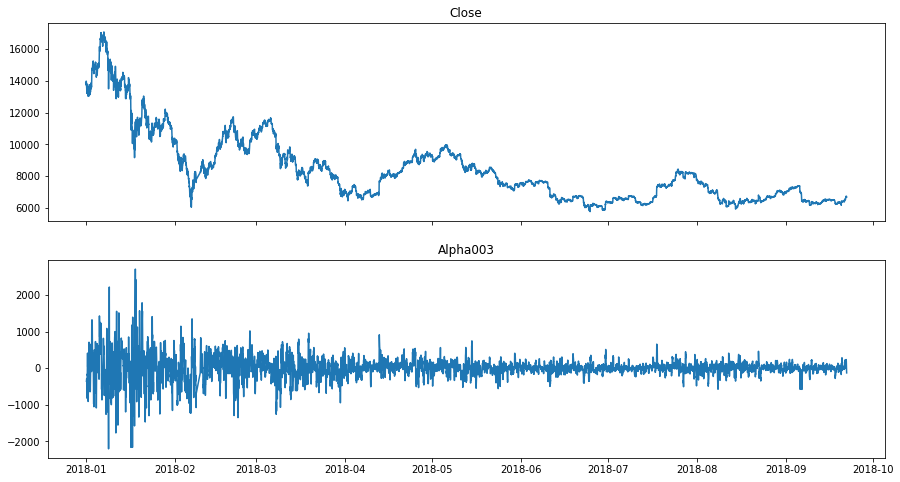

In [4]:
import pandas as pd
close=dv.get_ts('close', date_type='datetime')
df=pd.concat([close,alpha3],axis=1)
df.columns=['close','alpha3']
df.columns.name='BTCUSDT:binance'

import matplotlib.pyplot as plt
fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
ax.plot(close)
ax.set_title('Close')
ax1.plot(alpha3)
ax1.set_title('Alpha003')
plt.show()

**整个样本期间收益率与alpha3的相关系数**

可以看到，alpha3与收益率相关系数0.39，是正相关的，表明多方力量的增强与收益率上升是一致的，也体现了动量效应

In [5]:
df['change_pct']=df['close'].pct_change()
df[['change_pct', 'alpha3']].corr()

BTCUSDT:binance,change_pct,alpha3
BTCUSDT:binance,,
change_pct,1.000000,0.387318
alpha3,0.387318,1.000000


**进一步，考察alpha3对滞后收益率的影响**

可以看到，滞后期的相关性没有当期相关性明显，且在大约10期滞后出现峰值

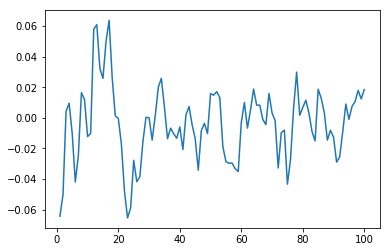

In [6]:
import matplotlib.pyplot as plt
import numpy as np
corr=[]
index=np.arange(1,101)
df1=df[['alpha3','change_pct']].dropna(how='any')
for i in index:
    x=df1['alpha3'].values[0:-i]
    y=df1['change_pct'].values[i:]
    corr.append(np.corrcoef(x,y)[0,1])
plt.plot(index, corr)

**利用alpha3超过均线打分，分数直方图展示，可以看到分数得分尾部集中**

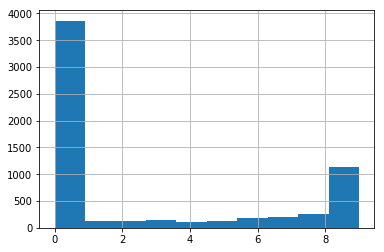

In [7]:
import talib as ta
import numpy as np
import pandas as pd


for t in np.arange(1,11):
    alpha3=df['alpha3'].values
    alpha3_ma=ta.MA(alpha3, t)
    df[str(t)]=(alpha3>alpha3_ma)&(alpha3>0)&(alpha3<300).astype(np.int16)

signal_df=df.iloc[:,3:]
signal_df["score"]=signal_df.sum(axis=1)
signal_df=signal_df.astype(float)
signal_df.score.hist()

**收盘价、信号得分以及移动平均线观察，可以初步定为5分以上做多，1分一下做空**

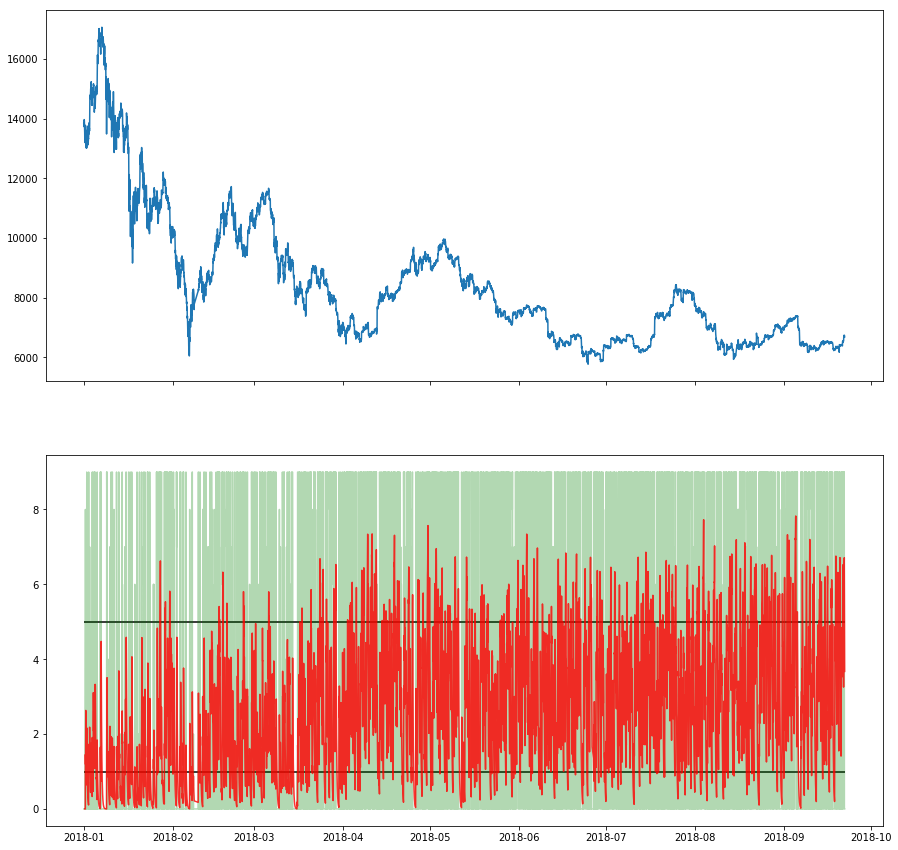

In [8]:
import matplotlib.pyplot as plt
from talib import abstract

fig, (ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
ax.plot(dv.get_ts('close',date_type='datetime'))
ax1.plot(signal_df['score'], 'g', alpha=0.3)
ax1.plot(abstract.EMA(signal_df,10,price='score'), 'r', alpha=0.8)
ax1.hlines(5, signal_df['score'].index[0], signal_df['score'].index[-1])
ax1.hlines(1, signal_df['score'].index[0], signal_df['score'].index[-1])
plt.show()

### 因子二：蜡烛图之十字启明星与吞噬形态

一般认为，十字启明星是底部反转信号，吞噬形态是顶部反转信号

In [9]:
import talib as ta
import matplotlib.pyplot as plt
import mpl_finance as mpf
warnings.filterwarnings('ignore')

from matplotlib.pylab import date2num
data = Time_dict.set_index('datetime')
data['candleTime'] = list(map(date2num, data.index))
candle = data.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

def draw_candle(candle, scatterX, scatterY, marker, s):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=s, marker=marker)
    ax.xaxis_date ()
    ax1.bar(data.index, data.volume)
    plt.show()

蜡烛图与成交量（十字启明星标记）:可以看到十字启明星预测底部效果不算太好，出现信号前期似乎都有一个成交量下降的过程

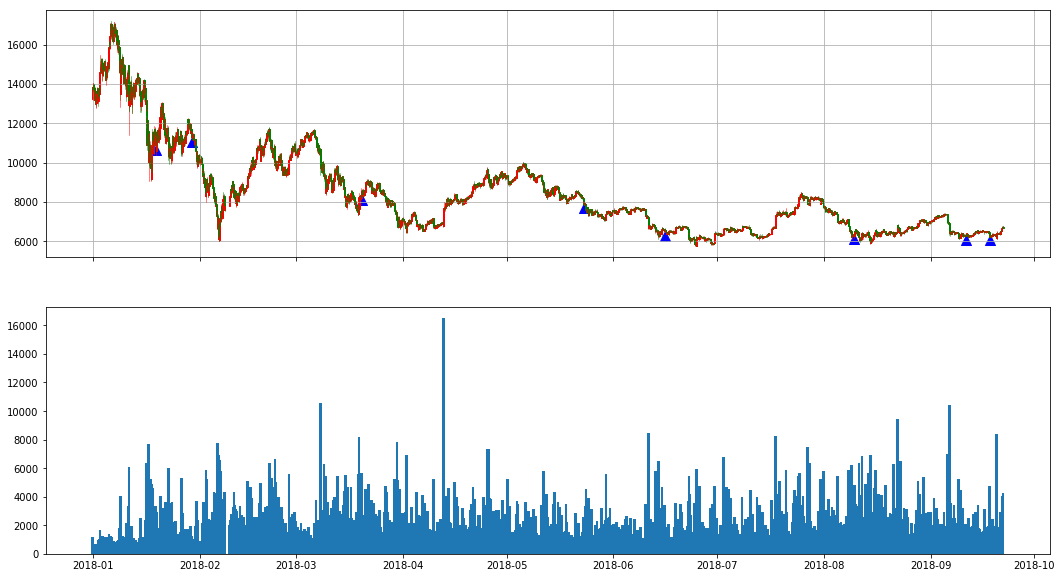

In [10]:
dv.add_formula('morning_doji_star', "If((Ta('CDLMORNINGDOJISTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)

morning_doji_star = dv.get_ts('morning_doji_star', date_type='datetime')
morning_doji_star_X = morning_doji_star[morning_doji_star['BTCUSDT:binance']==100].index
morning_doji_star_Y = data.loc[morning_doji_star_X, 'low']-200

draw_candle(candle, morning_doji_star_X, morning_doji_star_Y, marker='^', s=100)

蜡烛图与成交量（吞噬形态标记）：吞噬形态出现次数过多且容易产生假信号，如果有放量加以佐证，信号准确性会提高。

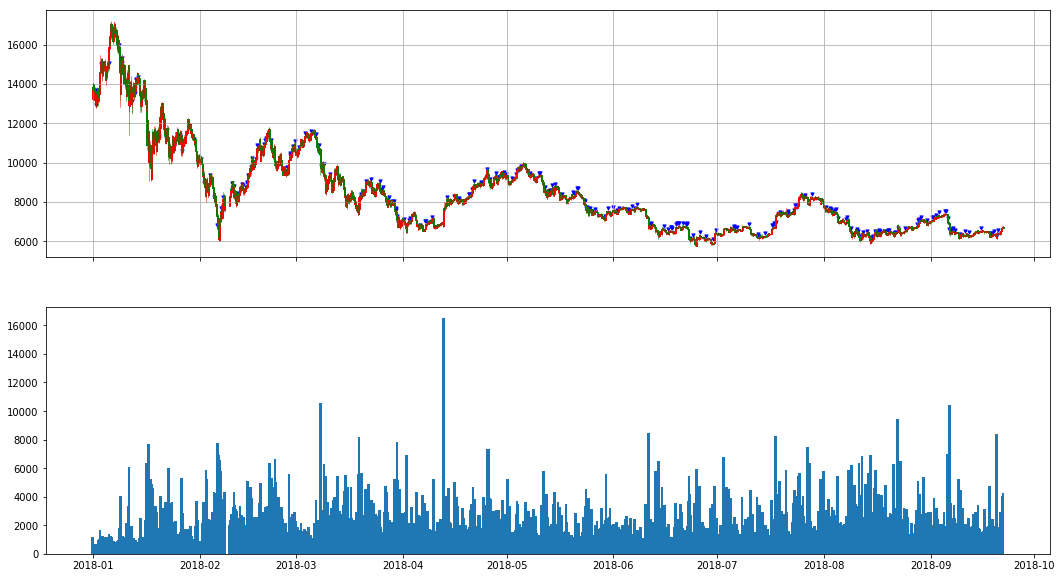

In [11]:
dv.add_formula('engulfing', "If((Ta('CDLENGULFING', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
engulfing = dv.get_ts('engulfing', date_type='datetime')
engulfing_X = engulfing[engulfing['BTCUSDT:binance']==100].index
engulfing_Y = data.loc[engulfing_X, 'low']+200
engulfing_X
draw_candle(candle, engulfing_X, engulfing_Y, 'v',s=10)

**启明星做多信号，吞噬形态+放量做空信号**